### ACROBOT ###


In [2]:
# Libraries will not be installed if running on ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed on your local system
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_acrobot.txt

You should consider upgrading via the '/Users/tennismichel/Coding/Python/venv-advml/bin/python3 -m pip install --upgrade pip' command.


In [14]:
import os
import numpy as np
import itertools
from itertools import count
import matplotlib.pyplot as plt
from tqdm import trange
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Set a seed for reproducing results
random_seed = 1234
np.random.seed(random_seed)
torch.manual_seed(random_seed)

Acrobot is a 2-link pendulum with only the second joint actuated.
Initially, both links point downwards. The goal is to swing the
end-effector at a height at least the length of one link above the base.
Both links can swing freely and can pass by each other, i.e., they don't
collide when they have the same angle.

**STATE:**
The state consists of the sin() and cos() of the two rotational joint
angles and the joint angular velocities :
[cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2].
For the first link, an angle of 0 corresponds to the link pointing downwards.
The angle of the second link is relative to the angle of the first link.
An angle of 0 corresponds to having the same angle between the two links.
A state of [1, 0, 1, 0, ..., ...] means that both links point downwards.

**ACTIONS:**
The action is either applying +1, 0 or -1 torque on the joint between
the two pendulum links.

In [15]:
# Define the environment
env = gym.make('Acrobot-v1')

# Set the seed for gym
env.seed(random_seed)

[1234]

In [16]:
# What is the type and size of the action space
print("Action space: {}".format(env.action_space))  # 3 discrete actions, 

# What does an action look like
sample_action = env.action_space.sample()  # Action can be one of these: 0, 1, 2
print("Sample action: {}".format(sample_action))  # Execute multiple times to see different actions
print("Type of action: {}".format(type(sample_action)))

# What is the type and size of the observation (state) space
print("Observationtate space: {}".format(env.observation_space))  # continuous states

# Which state does the agent start in?
initial_state = env.reset()
print("Initial state: {}".format(initial_state))  

# What is an observation
sample_observation = env.observation_space.sample()
print("Sample observation: {}".format(sample_observation))
print("Type of observation: {}".format(type(sample_observation)))

Action space: Discrete(3)
Sample action: 1
Type of action: <class 'int'>
Observationtate space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
Initial state: [ 0.99965389 -0.02630794  0.99678118 -0.08017036  0.0960371  -0.00889859]
Sample observation: [ -0.0857223   -0.5910831   -0.07993969   0.1420704    2.4562519
 -25.016588  ]
Type of observation: <class 'numpy.ndarray'>


In [60]:
class NeuralNetworkPolicy(nn.Module):
    def __init__(self):
        super(NeuralNetworkPolicy, self).__init__()
        
        # Layer definitions
        n_hidden = 100
        self.affine1 = nn.Linear(6, n_hidden)
        self.dropout1 = nn.Dropout(p=0.6)        
        self.affine2 = nn.Linear(n_hidden, n_hidden)
        self.dropout2 = nn.Dropout(p=0.6)
        self.affine3 = nn.Linear(n_hidden, 3)

        # Used for storing the log probabilities of the actions
        # which is required to compute the loss (and hence needed for the parameter update step)
        self.saved_log_probs = []
        
        # Used for tracking the rewards the agent recieves in an episode.
        self.rewards = []

    def forward(self, x):
        """
        Defines the forward pass of the policy network.
        
        Args:
            x (Tensor): The current state as observed by the agent.
        Returns:
            (Tensor): Action probabilities.
        """
        
        # Pass the input `x` through the following, where the output of the
        # previous step is the input for the next step
        # x -> affine1 -> droupout1 -> relu -> affine2 -> dropout2 -> relu -> affine3 -> softmax
        # The last 2 steps of the above steps are implemented already
        
        model = torch.nn.Sequential(
            self.affine1,
            self.dropout1,
            nn.ReLU(),
            self.affine2,
            self.dropout2,
            nn.ReLU()
        )
        
        x = model(x)
        numerical_prefs = self.affine3(x)  
        return F.softmax(numerical_prefs, dim=1)
    
    def select_action(self,state):
        """
        Selects an action for the agent, by sampling from the action probabilities
        produced by the network, based on the current state. Also stores the 
        log probability of the actions.
        
        Args:
            state (numpy array): The current state as observed by the agent.
            
        Returns:
            (int): Action to perform.
        """
        # Convert the state from a numpy array to a torch tensor
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        # Get the predicted probabilities from the policy network
        probs = self.forward(state)
        
        # Sample the actions according to their respective probabilities
        m = Categorical(probs)
        action = m.sample()
        
        # Also calculate the log of the probability for the selected action
        self.saved_log_probs.append(m.log_prob(action))
        
        # Return the chosen action
        return action.item()

    def save(self, state_file='policy_network.pt', save_dir='models'):
        """
        Saves a trained policy network.
        """
        # Save the model state
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        torch.save(self.state_dict(), os.path.join(save_dir, state_file))

    @staticmethod
    def load(state_file='models/policy_network.pt'):
        """
        Loads a trained policy network.
        """
        # Create a network object with the constructor parameters
        policy = NeuralNetworkPolicy()
        # Load the weights
        policy.load_state_dict(torch.load(state_file))
        # Set the network to evaluation mode
        policy.eval()
        return policy

In [61]:
def compute_returns(rewards, gamma):
    """
    Function for computing returns from the list of rewards observed during an episode.
    
    Hint: Take special care of the fact that in the algorithm, the list of rewards are for 
    steps 1,2,...,T. Since Python follows a zero-based indexing system, the kth reward is 
    accessed by: rewards[k-1].
    
    Args:
        rewards (list): Rewards observed in an episode [r1, r1, ..., rT] for T steps.
    Returns:
        (list): List of returns.
    """
    returns = list()
    len_rewards = len(rewards)
    for i, reward in enumerate(rewards):
        return_i = 0
        k = 0 # k is exponent of gamma - j iterates through relevant rewards
        for j in range(i, len_rewards):
            return_i += gamma**k * rewards[j]
            k += 1
        returns.append(return_i) 
    return returns

In [62]:
def finish_episode(policy, optimizer, gamma):
    """
    Performs the parameter updates of the policy network after an episode is completed.
    
    Args:
        policy (NeuralNetworkPolicy): The policy neural network.
        optimizer (child of torch.optim.Optimizer): Optimizer algorithm for gradient ascent.
        gamma (float): Discount factor in the range [0.0,1.0].
    """
    
    policy_loss = []

    # Define a small float which is used to avoid divison by zero
    eps = np.finfo(np.float32).eps.item()

    # Go through the list of observed rewards and calculate the returns
    returns = compute_returns(policy.rewards, gamma)

    # Convert the list of returns into a torch tensor
    returns = torch.tensor(returns)

    # Here we normalize the returns by subtracting the mean and dividing
    # by the standard deviation. Normalization is a standard technique in
    # deep learning and it improves performance, as discussed in 
    # http://karpathy.github.io/2016/05/31/rl/
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # Here, we deviate slightly from the standard REINFORCE algorithm
    # Think why we use `-log_prob * G` instead of `log_prob * G`
    for log_prob, G in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * G)

    # Reset the gradients of the parameters
    optimizer.zero_grad()

    # Compute the cumulative loss
    policy_loss = torch.cat(policy_loss).mean()

    # Backpropagate the loss through the network
    policy_loss.backward()

    # Perform a parameter update step
    optimizer.step()

    # Reset the saved rewards and log probabilities
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [63]:
def reinforce(policy, optimizer, gamma=0.9, log_interval=100, max_episodes=1000, save=False):
    """
    Implementation of the main body of the REINFORCE algorithm.
    
    Args:
        policy (NeuralNetworkPolicy): The policy neural network.
        optimizer (child of torch.optim.Optimizer): Optimizer algorithm for gradient ascent.
        gamma (float): Discount factor in the range [0.0,1.0]. Defaults to 0.9.
        log_interval (int): Prints the progress after this many episodes. Defaults to 100.
        max_episodes (int): Maximum number of episodes to train for. Defaults to 1000.
        save (bool): Whether to save the trained network. Defaults to False.
        
    Returns:
        ep_rewards (list): List of actual cumulative rewards in each episode. 
        running_rewards (numpy array): List of smoothed cumulative rewards in each episode. 
    """

    # To track the reward across consecutive episodes (smoothed)
    running_reward = -500

    # Lists to store the episodic and running rewards for plotting
    ep_rewards = list()
    running_rewards = list()

    # Start executing an episode
    for i_episode in range(0, max_episodes):

        # Steps you need to implement
        # 1. Reset the environment
        state = env.reset()
        t = 0
        
        # 2. Initialize `ep_reward` (the total reward for this episode)
        ep_reward = 0
        
        # 3. For each step of the episode
        while (True):
            # 3.1 Select an action using the policy network
            action = policy.select_action(state)
            # action = self.select_action(state)
            
            # 3.2 Perform the action and note the next state and reward and if the episode is done
            state, reward, done, info = env.step(action)
            
            # 3.3 Store the current reward in `policy.rewards`
            policy.rewards.append(reward)
            
            # 3.4 Increment the total reward in this episode
            ep_reward += reward
            
            # Steps in episode for output required
            t += 1
            
            # 3.5 Check if the episode is finished using the `done` variable and break if yes
            if (done):
                break

        # Update the running reward /return!!
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # Store the rewards for plotting
        ep_rewards.append(ep_reward)
        running_rewards.append(running_reward)
        
        # Perform the parameter update according to REINFORCE
        finish_episode(policy, optimizer, gamma)

        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        # Stopping criteria
        if running_reward > env.spec.reward_threshold:
            print('Running reward is now {} and the last episode ran for {} steps!'.format(running_reward, t))
            break
        if i_episode >= max_episodes:
            print('Max episodes exceeded, quitting.')
            break
    # Save the trained policy network
    if save:
        policy.save()

    return ep_rewards, running_rewards

In [64]:
def train_nn_policy(max_episodes=1000, **hyperparam_dict):
    """
    Function for training the neural network policy parameters with specified hyperparameters.
    """
    
    # Fetch the hyperparameters
    gamma = hyperparam_dict['gamma']
    learning_rate = hyperparam_dict['learning_rate']

    state_size = env.observation_space.shape[0]

    # Create the policy function and set the training mode
    policy = NeuralNetworkPolicy()
    policy.train()

    # Define the optimizer and set the learning rate
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    # Execute the REINFORCE algorithm
    ep_rewards, running_rewards = reinforce(policy, optimizer, max_episodes=max_episodes)
    
    del optimizer
    del policy
    
    return ep_rewards, running_rewards

In [69]:
# Actual training takes place here

# This will take a while to run

# A list for storing the hyperparameters and the corresponding results
results_neural_network = list()

# Run the REINFORCE algorithm 

# Run the REINFORCE algorithm 
hyperparam_dict = {'name': 'neural_network', 'gamma':0.99, 'learning_rate':1e-3}
ep_rewards, running_rewards = train_nn_policy(max_episodes=1500, **hyperparam_dict)

# Store the results
results_neural_network.append((hyperparam_dict, ep_rewards, running_rewards))

Episode 0	Last reward: -500.00	Average reward: -500.00
Episode 100	Last reward: -187.00	Average reward: -270.63
Episode 200	Last reward: -161.00	Average reward: -177.80
Episode 300	Last reward: -94.00	Average reward: -139.29
Episode 400	Last reward: -90.00	Average reward: -120.93
Episode 500	Last reward: -147.00	Average reward: -135.99
Episode 600	Last reward: -161.00	Average reward: -122.32
Episode 700	Last reward: -101.00	Average reward: -115.84
Episode 800	Last reward: -88.00	Average reward: -122.61
Episode 900	Last reward: -175.00	Average reward: -125.72
Episode 1000	Last reward: -165.00	Average reward: -117.22
Episode 1100	Last reward: -117.00	Average reward: -106.94
Episode 1200	Last reward: -137.00	Average reward: -121.08
Episode 1300	Last reward: -95.00	Average reward: -111.84
Episode 1400	Last reward: -114.00	Average reward: -108.73


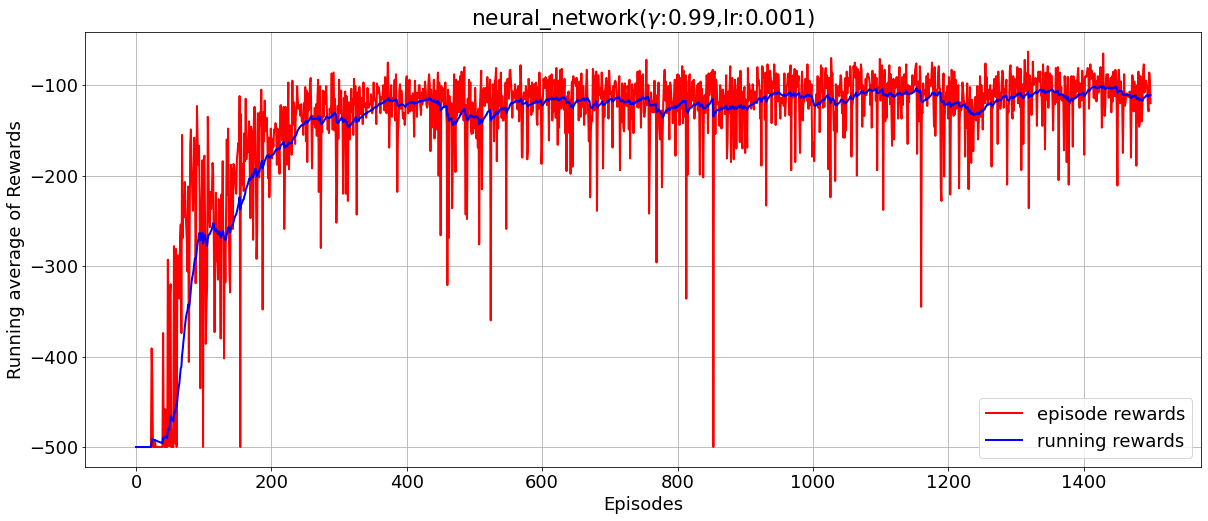

In [70]:
plt.rcParams.update({'font.size': 18})

# Plot the results
fig = plt.figure(1, figsize=(20,8))

for result in results_neural_network:
    hp = result[0]
    running_rewards = result[2]
    title_str = hp['name'] + '($\gamma$:' + str(hp['gamma']) + ',lr:' + str(hp['learning_rate']) + ')'
    plt.plot(range(len(ep_rewards)), ep_rewards, lw=2, color="red", label="episode rewards")
    plt.plot(range(len(running_rewards)), running_rewards, lw=2, color="blue", label="running rewards")
    plt.title(title_str)

plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Running average of Rewards')
plt.legend(ncol=1)
plt.show()